# Explicit model predictive control (Explicit MPC) 
In this notebook we will liik at explicit mpc for controlling the cart pendulum model. Explicit MPC allows to solve for a piecewise linear affine solution of the model predictive control problem over a given region offline. This means that the online calculations reduce to evaluating this function at runtime.  

In [1]:
# Set relative path to parent directory
import sys, os
sys.path.insert(0, os.path.abspath('..'))

In [2]:
# Import environment
from environments.cartPendulum import cartPendulum

env = cartPendulum(mass_cart=1, mass_pendulum=0.1, length_pendulum=1, gravity=9.81)
env.step_size = 0.02

Unfortunetly there is no efficient way of solving the multiparametric programming problem in python. We therfore use matlab with the optimization tool YALMIP and Multi-Parametric Toolbox to solve the problem, and import the solution into python.

In [10]:
from IPython.display import Markdown

with open('cart_pendulum_empc.m', 'r') as file:
    code = file.read()

Markdown("""## Matlab code \n ```matlab \n{} ```""".format(code))

## Matlab code 
 ```matlab 
yalmip('clear')
clear all

%% Cart pendulum model
m_c = 1.0;      % Cart mass
m_p = 0.1;      % Pendulum mass
l = 1.0;        % Pendulum length
g = 9.81;       % Gravity

% The linearized model about the equilibrium

A = [0, 0, 1, 0;
     0, 0, 0, 1;
     0, -g*m_p/m_c, 0, 0;
     0, g*(m_c + m_p)/(l*m_c), 0, 0];

B = [0; 0; 1/m_c; -1/(l*m_c)];

% The discrete time linear model
Ts = 0.2;
sys = c2d(ss(A, B, [], []), Ts, 'zoh');

Ad = sys.A;

Bd = sys.B;


%% Model predictive control - Explicit multi-parametric solution

nx = 4; % Number of states
nu = 1; % Number of inputs

% Prediction horizon
N = 15;

% Weighting matrices
Q = diag([1, 10, 1, 1]);
R = 1;

% State bounds
bound = [2; 0.5; 3; pi];

% States x(k), ..., x(k+N)
x = sdpvar(repmat(nx,1,N),repmat(1,1,N));
% Inputs u(k), ..., u(k+N) (last one not used)
u = sdpvar(repmat(nu,1,N),repmat(1,1,N));
% Binary for PWA selection
d = binvar(repmat(4,1,N),repmat(1,1,N));

constraints = [];
objective = 0;

for k = N-1:-1:1   

    % Feasible region
    constraints = [constraints , -20    <= u{k}   <= 20,
                                 -bound <= x{k}   <= bound,
                                 -bound <= x{k+1} <= bound];
    % PWA Dynamics
    constraints = [constraints ,x{k+1} == Ad*x{k}+Bd*u{k}];

    % Add stage cost to total cost
    objective = objective + x{k}'*Q*x{k} + u{k}'*R*u{k};
end

[sol,diagn,Z,Valuefcn,Optimizer] = solvemp(constraints,objective ,[],x{1},u{1});

%% Simulate
Ts_sim = 0.01;
sim_time = 500; 
x0 = [0; 0.3; 0; 0];
x_vec = zeros(nx, sim_time);
t_vec = 0:Ts_sim:(sim_time-1)*Ts_sim;
x_vec(:, 1) = x0;
u_vec = zeros(nu, sim_time);
for i = 1:sim_time - 1
    assign(x{1},x_vec(:, i));
    u_t = value(Optimizer);
    u_vec(i) = u_t;
    x_vec(:, i + 1) = x_vec(:, i) + Ts_sim*(A*x_vec(:, i) + B*u_t);
end

figure; plot(t_vec, x_vec);
figure; plot(t_vec, u_vec);

%% Save solution to file
pwa_u = struct('Fi', {sol{1}.Fi}, 'Gi', {sol{1}.Gi}, 'Hi', {[]}, 'Ki', {[]});
for i = 1:length(sol{1}.Fi)
    [H, K] = double(sol{1}.Pn(i));
    pwa_u.Hi{i} = H;
    pwa_u.Ki{i} = K;
end
save('empc_sol.mat', 'pwa_u') ```

In [4]:
import scipy.io as sio
import numpy as np

# Import solution struct
sol = sio.loadmat("empc_sol.mat")

# Extract piecwise affine solution
Fi = sol['pwa_u'][0,0]['Fi'][0]
Gi = sol['pwa_u'][0,0]['Gi'][0]
Hi = sol['pwa_u'][0,0]['Hi'][0]
Ki = sol['pwa_u'][0,0]['Ki'][0]

The explicit solution is given by the piecewise affine function
$$
u(x) = 
\begin{cases}
    F_1 x + g_1 \mbox{ if } H_1 x \leq K_i \\
    \quad \quad \quad \quad \vdots \\
    F_M x + g_M \mbox{ if } H_M x \leq K_M 
\end{cases}
$$

In [5]:
def empc(x):
    for i in range(Hi.shape[0]):
        if ((Hi[i]@x).flatten() <= Ki[i].flatten()).all():
            #print(Hi[i]@x + Ki[i])
            #print(i)
            return(Fi[i]@x).T + Gi[i]

In [6]:
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib import animation
from IPython.display import HTML

# Simulate the environment for n_steps and save states in X
n_steps = 500
X = np.zeros((len(env.x), n_steps))
theta = (2*np.random.random() - 1)*0.4
state = env.init([0, 0.46, 0, 0])
U = np.zeros((n_steps))
for step in range(n_steps):
    X[:, step] = env.x
    if step%10 == 0:
        u = empc(env.x)
    U[step] = u
    state = env.step(u)

# Create the figure
fig = plt.figure()
ax = plt.axes(xlim=(-2, 2), ylim=(-1.1, 1.1), aspect='equal')
line, = ax.plot([], [], lw=2, marker='o', markersize=6)
rect = Rectangle([X[0][0] - 0.2, -0.1],0.4, 0.2, fill=True, color='red', ec='black')
ax.add_patch(rect)

animate = lambda i: (rect.set_xy([X[0,i] - 0.2, -0.1]), 
                     line.set_data([X[0,i], X[0,i] + np.sin(X[1, i])],[0, np.cos(X[1, i])]))

# Create and display animation
plt.close()
anim = animation.FuncAnimation(fig, animate, interval = env.step_size*1000, frames = n_steps)

In [7]:
HTML(anim.to_html5_video())

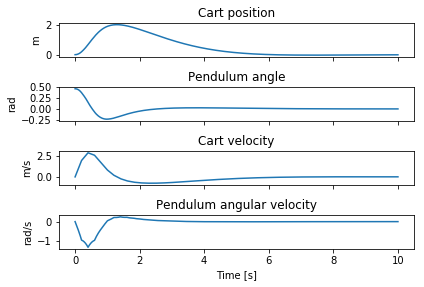

In [8]:
# Plot trajectoryimulating
#%matplotlib auto
nx = 4
nu = 1
t = np.linspace(0, n_steps*env.step_size, X.shape[1])
names = ["Cart position", "Pendulum angle", "Cart velocity", "Pendulum angular velocity"]
units = ["m", "rad", "m/s", "rad/s"]
fig, axarr = plt.subplots(nx, sharex=True)
for i in range(nx):
    axarr[i].plot(t, X.T[:, i])
    axarr[i].title.set_text(names[i])
    axarr[i].set_ylabel(units[i])

fig.tight_layout()
fig.subplots_adjust(top=0.88)
plt.xlabel('Time [s]')
plt.show()

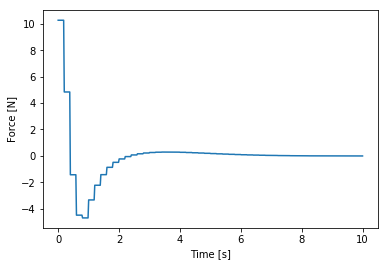

In [9]:
# Plot input
t = np.linspace(0, n_steps*env.step_size, X.shape[1])
plt.figure()
plt.ylabel("Force [N]")
plt.xlabel("Time [s]")
plt.plot(t, U)
plt.show()